In [127]:
import torch
print("Using torch", torch.__version__)

Using torch 2.2.1+cu121


In [128]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device) #mnist is a small dataset, so working on cpu is fine

Device cpu


In [130]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

## 1. (Neural Network) Task-0:
Download the MNIST dataset using torch-
vision. Split data into train, test, and validation. Apply the following

augmentations to images: RandomRotation, RandomCrop, ToTensor, and
Normalize. [2 pts]

In [131]:
transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomCrop(28, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

#percentage of data for training, testing, and validation
train_percentage = 0.8
val_percentage = 0.1
test_percentage = 0.1

#sizes of each split
train_size = int(train_percentage * len(train_dataset))
val_size = int(val_percentage * len(train_dataset))
test_size = len(train_dataset) - train_size - val_size

#split the training dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    train_dataset, [train_size, val_size, test_size])


In [56]:
len(train_dataset)

48000

In [11]:
len(test_dataset)

6000

In [13]:
val_size

6000

In [14]:
test_size

6000

In [15]:
train_size

48000

## Task-1:
Plot a few images from each class. Create a data loader for the
training dataset as well as the testing dataset. [2 pts]

In [132]:
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')#ten classes

In [133]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=4,
                                          shuffle=True, num_workers=2)
#The loader is an instance of DataLoader. Each time it is read, we get a batch of features and targets from the original dataset.
testloader=torch.utils.data.DataLoader(test_dataset, batch_size=4,
                                          shuffle=False, num_workers=2)
valloader=torch.utils.data.DataLoader(val_dataset, batch_size=4,
                                          shuffle=False, num_workers=2)

In [117]:
import pprint

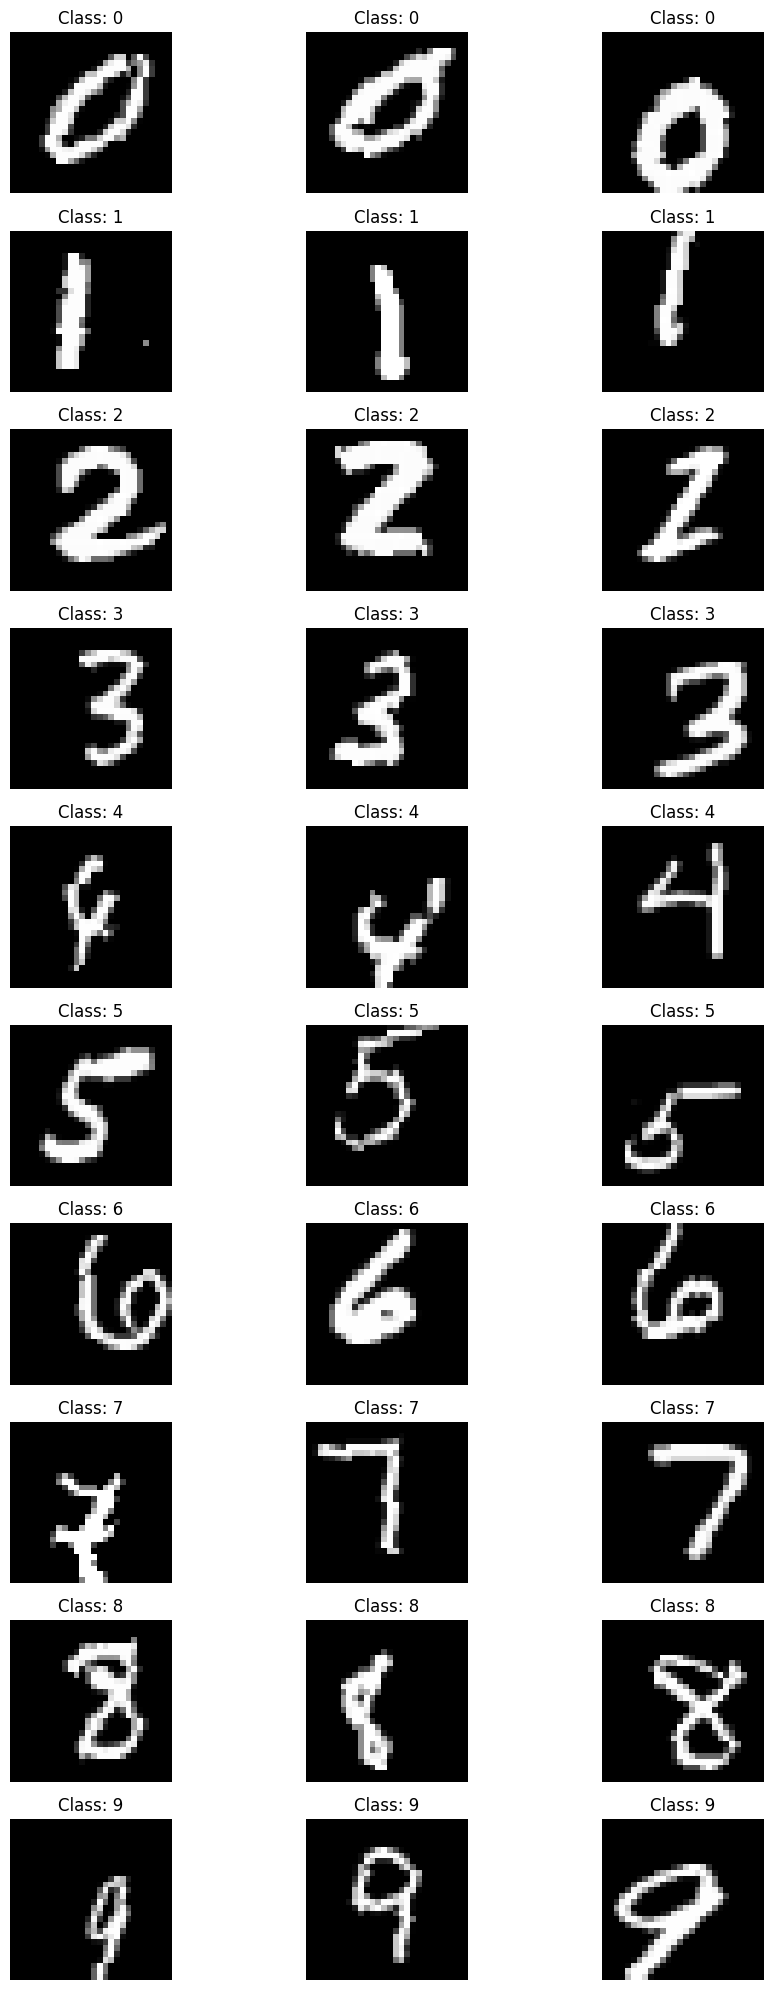

In [134]:
class_images = [[] for _ in range(len(classes))]

# Collecting images from each class
for images, labels in trainloader:
    for image, label in zip(images, labels):
        class_images[label].append(image)
    if all(len(images) >= 3 for images in class_images):
        break
plt.figure(figsize=(10, 20))
for i in range(len(classes)):
    for j in range(3):  #Plotting 3 images from each class
        plt.subplot(len(classes), 3, i*3 + j + 1)
        plt.imshow(class_images[i][j].numpy().squeeze(), cmap='gray')
        plt.title(f'Class: {i}')
        plt.axis('off')
plt.tight_layout()
plt.show()


## Task-2:
Write a 3-Layer MLP using PyTorch all using Linear layers. Print
the number of trainable parameters of the model. [4 pts]

In [135]:
#defining the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = x.view(-1, self.num_flat_features(x))
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

### Setting the Hyperparameters

In [136]:
input_size = 28 * 28  #MNIST image size
hidden_size1 = 64 #variable could change
hidden_size2 = 32 #variable
output_size = 10  # the number of classes in MNIST
learning_rate=0.001
model = MLP(input_size, hidden_size1, hidden_size2, output_size)

#Count the number of trainable parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters:", total_params)

Number of trainable parameters: 52650


## Task-3:
Train the model for 5 epochs using Adam as the optimizer and
CrossEntropyLoss as the Loss Function. Make sure to evaluate the model
on the validation set after each epoch and save the best model as well as log
the accuracy and loss of the model on training and validation data at the
end of each epoch. [4 pts]

In [137]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= learning_rate)

In [138]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []



def train(model, train_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct / total
    return epoch_loss, epoch_accuracy
def test(model, test_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    test_accuracy = correct / total
    return test_accuracy
# Validation function
def validate(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = correct / total
    return epoch_loss, epoch_accuracy
# Training loop with test set evaluation
test_accuracies = []
best_test_accuracy = 0.0
best_val_accuracy = 0.0
for epoch in range(5):
    train_loss, train_accuracy = train(model, trainloader, optimizer, criterion)
    val_loss, val_accuracy = validate(model, valloader, criterion)
    test_accuracy = test(model, testloader, criterion)  # Evaluate on test set

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    test_accuracies.append(test_accuracy)

    print(f'Epoch {epoch+1}/{5}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}')
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')

print(f'Best validation accuracy: {best_val_accuracy:.4f}')








Epoch 1/5, Train Loss: 0.6655, Train Accuracy: 0.7843, Val Loss: 0.4696, Val Accuracy: 0.8603, Test Accuracy: 0.8563
Epoch 2/5, Train Loss: 0.4045, Train Accuracy: 0.8755, Val Loss: 0.3680, Val Accuracy: 0.8892, Test Accuracy: 0.8833
Epoch 3/5, Train Loss: 0.3420, Train Accuracy: 0.8945, Val Loss: 0.3094, Val Accuracy: 0.8992, Test Accuracy: 0.9028
Epoch 4/5, Train Loss: 0.3213, Train Accuracy: 0.9017, Val Loss: 0.3092, Val Accuracy: 0.9037, Test Accuracy: 0.8955
Epoch 5/5, Train Loss: 0.3070, Train Accuracy: 0.9066, Val Loss: 0.2877, Val Accuracy: 0.9073, Test Accuracy: 0.9090
Best validation accuracy: 0.9073


## Task-4:
Visualize correct and Incorrect predictions along with Loss-Epoch
and Accuracy-Epoch graphs for both training and validation. [3 pts]

In [139]:
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, test_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.title('Loss vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
    plt.plot(epochs, test_accuracies, 'g-', label='Test Accuracy')
    plt.title('Accuracy vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()



In [140]:
# Load the best model
best_model = MLP(input_size, hidden_size1, hidden_size2, output_size)
best_model.load_state_dict(torch.load('best_model.pth'))



<All keys matched successfully>

In [141]:
# Evaluate on validation data to get predictions
def get_predictions(model, data_loader):
    predictions = []
    targets = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.tolist())
            targets.extend(labels.tolist())
    return predictions, targets

val_predictions, val_targets = get_predictions(best_model, valloader)



In [142]:
#Get indices of correct and incorrect predictions
correct_indices = [i for i, (pred, target) in enumerate(zip(val_predictions, val_targets)) if pred == target]
incorrect_indices = [i for i, (pred, target) in enumerate(zip(val_predictions, val_targets)) if pred != target]



val_targets_np = np.array(val_targets)
val_predictions_np = np.array(val_predictions)

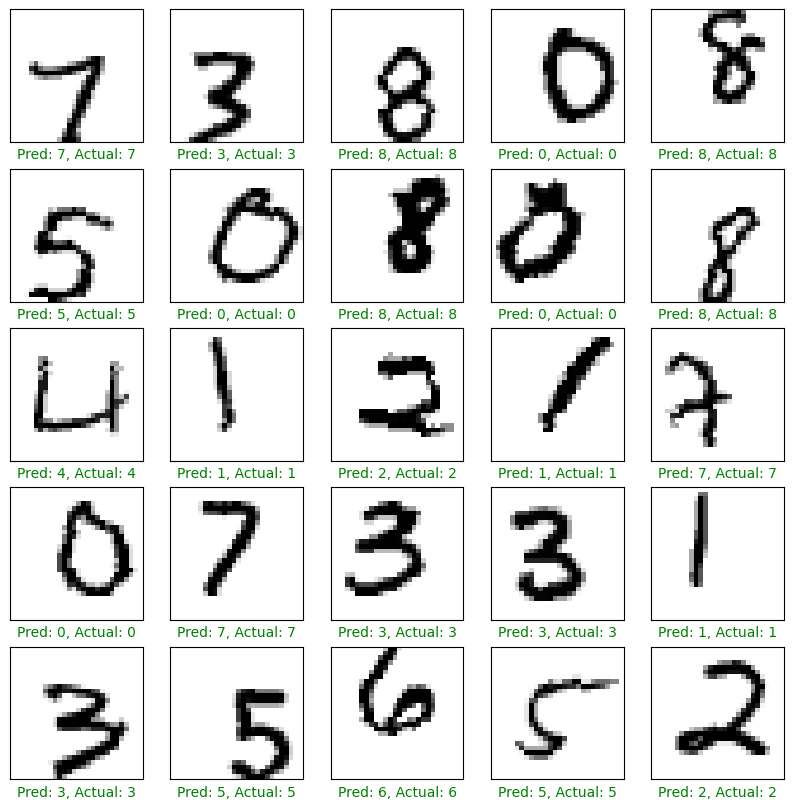

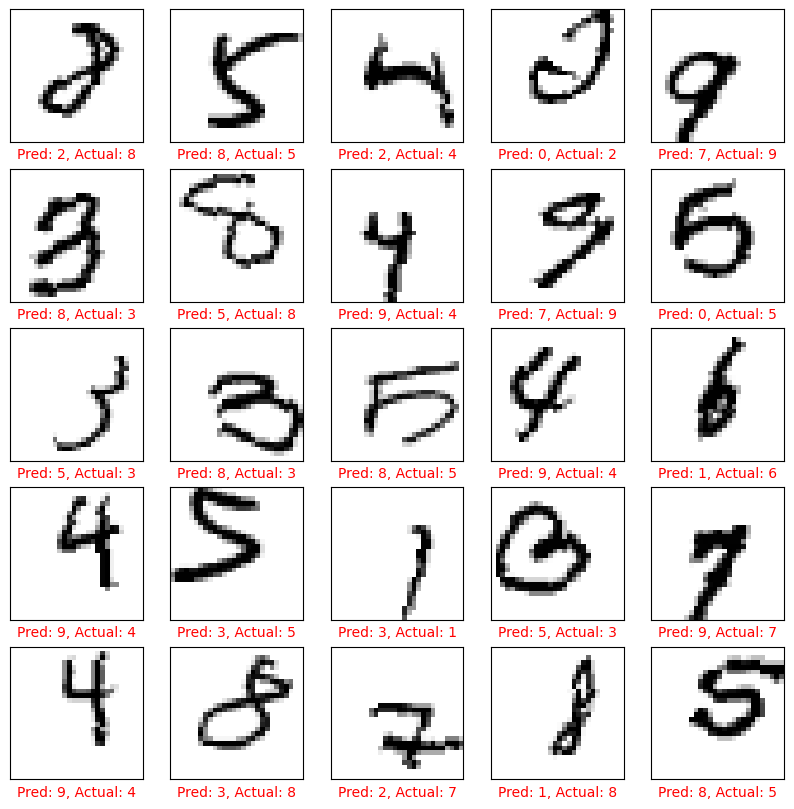

In [147]:
# Plotting correct and incorrect predictions
def visualize_predictions(images, labels, predictions, correct=True):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i].reshape(28, 28), cmap=plt.cm.binary)
        if correct:
            plt.xlabel(f'Pred: {predictions[i]}, Actual: {labels[i]}', color='green')
        else:
            plt.xlabel(f'Pred: {predictions[i]}, Actual: {labels[i]}', color='red')
    plt.show()




visualize_predictions([val_dataset[i][0] for i in correct_indices], val_targets_np[correct_indices], val_predictions_np[correct_indices], correct=True)
visualize_predictions([val_dataset[i][0] for i in incorrect_indices], val_targets_np[incorrect_indices], val_predictions_np[incorrect_indices], correct=False)

# visualize_predictions([val_dataset[i][0] for i in correct_indices], val_targets[correct_indices], val_predictions[correct_indices], correct=True)
# visualize_predictions([val_dataset[i][0] for i in incorrect_indices], val_targets[incorrect_indices], val_predictions[incorrect_indices], correct=False)
# Plot loss and accuracy


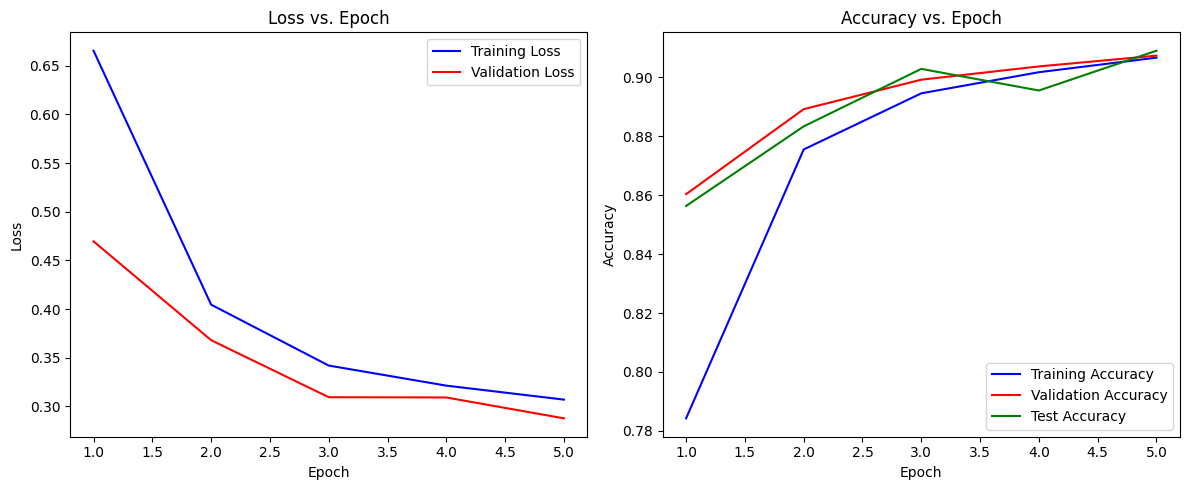

In [144]:
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, test_accuracies)

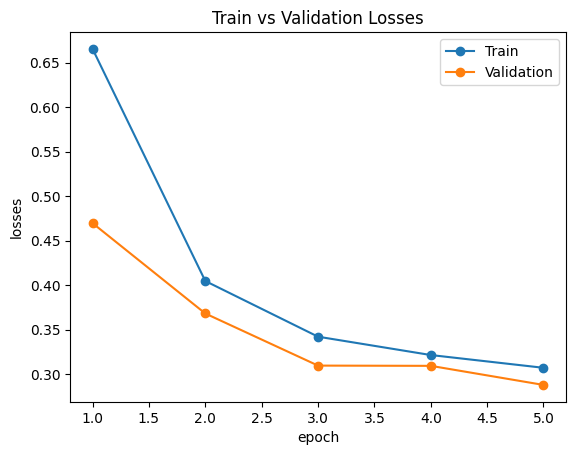

In [145]:
plt.plot(range(1, len(train_losses) + 1), train_losses, '-o', label='Train')
plt.plot(range(1, len(val_losses) + 1), val_losses, '-o', label='Validation')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Validation'])
plt.title('Train vs Validation Losses')

plt.show()

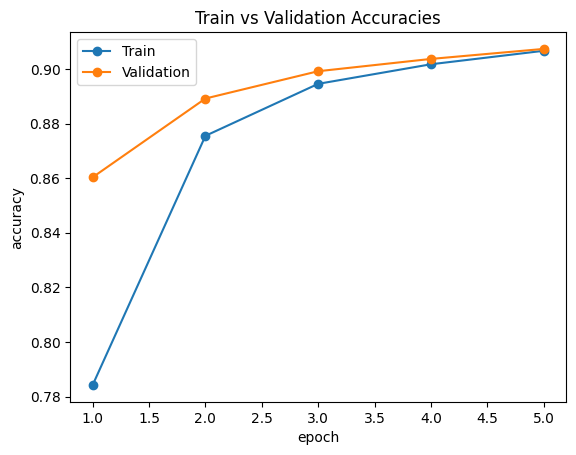

In [146]:
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, '-o', label='Train')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, '-o', label='Validation')

plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Validation'])
plt.title('Train vs Validation Accuracies')

plt.show()